In [1]:
import pandas_datareader as pdr
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num , DateFormatter
import datetime as dt
import quandl as q
q.ApiConfig.api_key = '88Yx6sJ8EDQzCQZw427L'

In [17]:
def get(tickers, startdate, enddate):
  def data(ticker):
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map (data, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['AAPL', 'MSFT', 'IBM', 'GOOG']
all_data = get(tickers, datetime.datetime(2006, 10, 1), datetime.datetime(2021, 1, 1))

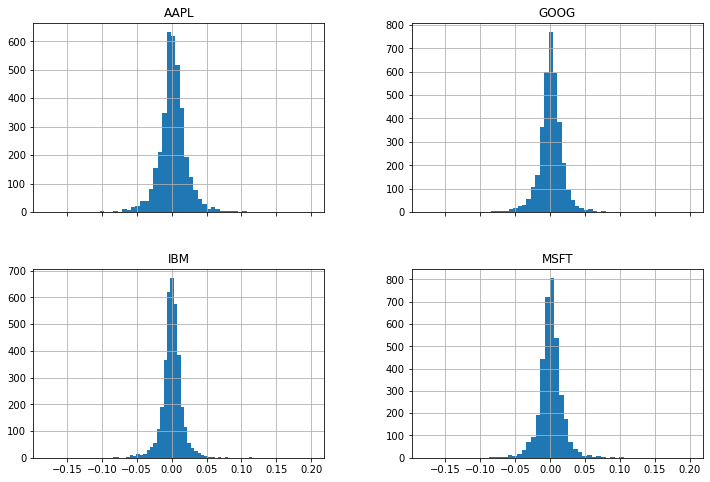

In [18]:
# Import matplotlib
import matplotlib.pyplot as plt 

# Isolate the `Adj Close` values and transform the DataFrame
daily_close_px = all_data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')

# Calculate the daily percentage change for `daily_close_px`
daily_pct_change = daily_close_px.pct_change()

# Plot the distributions
daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8))

# Show the resulting plot
plt.show()

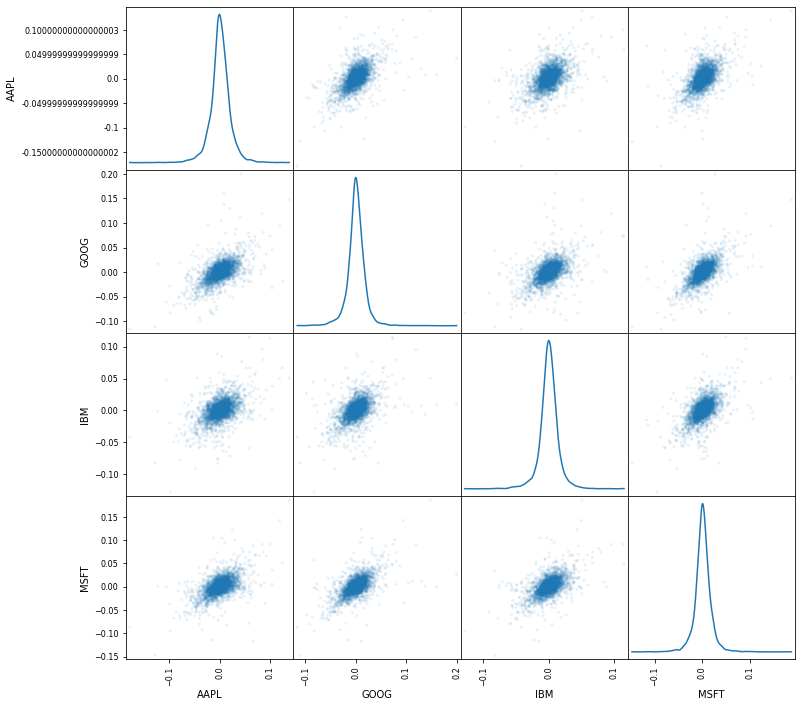

In [19]:
# Import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix


# Plot a scatter matrix with the `daily_pct_change` data 
scatter_matrix(daily_pct_change, diagonal='kde', alpha=0.1,figsize=(12,12))

# Show the plot
plt.show()

In [25]:
# Isolate the adjusted closing prices 
adj_close_px = aapl['Adj Close']

# Calculate the moving average
moving_avg = adj_close_px.rolling(window=40).mean()

# Inspect the result
print(moving_avg[-10:])

Date
2020-12-17    118.622635
2020-12-18    118.900369
2020-12-21    119.235072
2020-12-22    119.660776
2020-12-23    120.024796
2020-12-24    120.548834
2020-12-28    121.088050
2020-12-29    121.742987
2020-12-30    122.371420
2020-12-31    122.932425
Name: Adj Close, dtype: float64


In [26]:
aapl = pdr.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2006, 10, 1), 
                          end=datetime.datetime(2021, 1, 1))

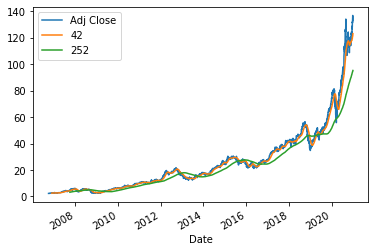

In [27]:
# Import matplotlib 
import matplotlib.pyplot as plt

# Short moving window rolling mean
aapl['42'] = adj_close_px.rolling(window=40).mean()

# Long moving window rolling mean
aapl['252'] = adj_close_px.rolling(window=252).mean()

# Plot the adjusted closing price, the short and long windows of rolling means
aapl[['Adj Close', '42', '252']].plot()

# Show plot
plt.show()

In [23]:
adj_close_px.head()

Ticker,AAPL
Date,
2006-10-02,NaN
2006-10-03,-0.010420
2006-10-04,0.017549
2006-10-05,-0.007296
2006-10-06,-0.008152
